# DenseNet

因为 ResNet 提出了跨层链接的思想，这直接影响了随后出现的卷积网络架构，其中最有名的就是 CVPR 2017 的 Best Paper，DenseNet。DenseNet 和 ResNet 不同在于 ResNet 是跨层求和，而 DenseNet 是跨层将特征在通道维度进行拼接，下面可以看看他们两者的图示：

![cnn_vs_resnet_vs_densenet.png](images/cnn_vs_resnet_vs_densenet.png)

第2张图是 ResNet，第3张图是 DenseNet，因为是在通道维度进行特征的拼接，所以底层的输出会保留进入所有后面的层，这能够更好的保证梯度的传播，同时能够使用低维的特征和高维的特征进行联合训练，能够得到更好的结果。

DenseNet主要的优点包括：
1. 减轻了vanishing-gradient（梯度消失）
2. 加强了feature的传递
3. 更有效地利用了feature
4. 一定程度上较少了参数数量

在深度学习网络中，随着网络深度的加深，梯度消失问题会愈加明显，目前很多论文都针对这个问题提出了解决方案，比如ResNet，Highway Networks，Stochastic depth，FractalNets等，尽管这些算法的网络结构有差别，但是核心都在于：**create short paths from early layers to later layers**。延续这个思路，那就是在保证网络中层与层之间最大程度的信息传输的前提下，直接将所有层连接起来。

先放一个dense block的结构图。在传统的卷积神经网络中，如果你有L层，那么就会有L个连接，但是在DenseNet中，会有 **L(L+1)/2** 个连接。简单讲，就是每一层的输入来自前面所有层的输出。如下图：x0是input，H1的输入是x0（input），H2的输入是x0和x1（x1是H1的输出）……

![DesNet_arch.png](images/DesNet_arch.png)

## 1. Dense_Block
DenseNet 主要由 Dense Block 构成，下面我们来实现一个 Densen Block

In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from torchvision import transforms as tfs

首先定义一个卷积块，这个卷积块的顺序是 bn -> relu -> conv

In [2]:
def Conv_Block(in_channel, out_channel):
    layer = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.ReLU(True),
        nn.Conv2d(in_channel, out_channel, 3, padding=1, bias=False)
    )
    return layer

Dense Block 将每次的卷积的输出称为 `growth_rate`，因为如果输入是 `in_channel`，有 n 层，那么输出就是 `in_channel + n * growh_rate`

In [3]:
class Dense_Block(nn.Module):
    def __init__(self, in_channel, growth_rate, num_layers):
        super(Dense_Block, self).__init__()
        block = []
        channel = in_channel
        for i in range(num_layers):
            block.append(Conv_Block(channel, growth_rate))
            channel += growth_rate
            
        self.net = nn.Sequential(*block)
        
    def forward(self, x):
        for layer in self.net:
            out = layer(x)
            x = torch.cat((out, x), dim=1)
        return x

我们验证一下输出的 channel 是否正确

In [4]:
test_net = Dense_Block(3, 12, 3)
test_x = Variable(torch.zeros(1, 3, 96, 96))
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 96 x 96
output shape: 39 x 96 x 96


除了 dense block，DenseNet 中还有一个模块叫过渡层（transition block），因为 DenseNet 会不断地对维度进行拼接， 所以当层数很高的时候，输出的通道数就会越来越大，参数和计算量也会越来越大，为了避免这个问题，需要引入过渡层将输出通道降低下来，同时也将输入的长宽减半，这个过渡层可以使用 1 x 1 的卷积

In [5]:
def Transition_Block(in_channel, out_channel):
    trans_layer = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.ReLU(True),
        nn.Conv2d(in_channel, out_channel, 1),
        nn.AvgPool2d(2, 2)
    )
    return trans_layer

验证一下过渡层是否正确

In [6]:
test_net = Transition_Block(3, 12)
test_x = Variable(torch.zeros(1, 3, 96, 96))
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 96 x 96
output shape: 12 x 48 x 48


## 2. DenseNet

最后我们定义 DenseNet

In [9]:
class DenseNet(nn.Module):
    def __init__(self, in_channel, num_classes, growth_rate=32, block_layers=[6, 12, 24, 16]):
        super(DenseNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=64, 
                      kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        channels = 64
        block = []
        for i, layers in enumerate(block_layers):
            block.append(Dense_Block(channels, growth_rate, layers))
            channels += layers * growth_rate
            if i != len(block_layers) - 1:
                block.append(Transition_Block(channels, channels // 2)) # 通过 transition 层将大小减半，通道数减半
                channels = channels // 2
        
        self.block2 = nn.Sequential(*block)
        self.block2.add_module('bn', nn.BatchNorm2d(channels))
        self.block2.add_module('relu', nn.ReLU(True))
        self.block2.add_module('avg_pool', nn.AvgPool2d(3))
        
        self.classifier = nn.Linear(channels, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [11]:
test_net = DenseNet(3, 10)
test_x = Variable(torch.zeros(1, 3, 96, 96))
test_y = test_net(test_x)
print('output: {}'.format(test_y.shape))

output: torch.Size([1, 10])


In [12]:
from utils import train

def data_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x
     
train_set  = CIFAR10('../../data', train=True,  transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set   = CIFAR10('../../data', train=False, transform=data_tf)
test_data  = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = DenseNet(3, 10)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [13]:
res = train(net, train_data, test_data, 20, optimizer, criterion)

[ 0] Train:(L=1.398217, Acc=0.485654), Valid:(L=1.140475, Acc=0.589102), T: 00:01:27
[ 1] Train:(L=0.977232, Acc=0.655091), Valid:(L=0.878000, Acc=0.688192), T: 00:01:27
[ 2] Train:(L=0.765218, Acc=0.732537), Valid:(L=0.722094, Acc=0.746242), T: 00:01:27
[ 3] Train:(L=0.622742, Acc=0.782649), Valid:(L=0.603473, Acc=0.791337), T: 00:01:27
[ 4] Train:(L=0.516785, Acc=0.818095), Valid:(L=0.558635, Acc=0.809434), T: 00:01:27
[ 5] Train:(L=0.429744, Acc=0.849984), Valid:(L=0.562023, Acc=0.815961), T: 00:01:27
[ 6] Train:(L=0.353802, Acc=0.876559), Valid:(L=0.590441, Acc=0.806369), T: 00:01:27
[ 7] Train:(L=0.287238, Acc=0.900715), Valid:(L=0.549039, Acc=0.826642), T: 00:01:27
[ 8] Train:(L=0.234364, Acc=0.916980), Valid:(L=0.518194, Acc=0.841278), T: 00:01:27
[ 9] Train:(L=0.182421, Acc=0.935422), Valid:(L=0.522031, Acc=0.850376), T: 00:01:27
[10] Train:(L=0.147457, Acc=0.948170), Valid:(L=0.577835, Acc=0.840289), T: 00:01:27
[11] Train:(L=0.111591, Acc=0.960938), Valid:(L=0.541511, Acc=0.8

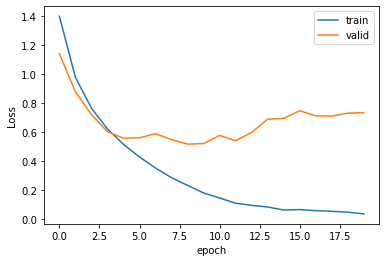

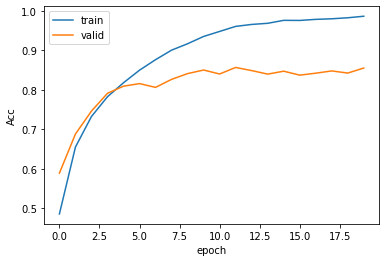

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(res[0], label='train')
plt.plot(res[2], label='valid')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('fig-res-densenet-train-validate-loss.pdf')
plt.show()

plt.plot(res[1], label='train')
plt.plot(res[3], label='valid')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(loc='best')
plt.savefig('fig-res-densenet-train-validate-acc.pdf')
plt.show()

# save raw data
import numpy
numpy.save('fig-res-densenet_data.npy', res)

DenseNet 将残差连接改为了特征拼接，使得网络有了更稠密的连接

## 参考
* [DenseNet算法详解](https://blog.csdn.net/u014380165/article/details/75142664)
* [DenseNet详解](https://zhuanlan.zhihu.com/p/43057737)